In [96]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn import model_selection
import pandas as pd
import numpy as np

comme dit dans le court

Détecter les valeurs manquantes (NaN).
Repérer les valeurs aberrantes dans la vitesse.
Gérer les erreurs textuelles dans la tension de batterie.
Remplacer ou interpoler les valeurs manquantes.
Filtrer ou corriger les valeurs aberrantes.
Remplacer les erreurs textuelles par une valeur acceptable ou les ignorer


In [ ]:
# clean
df = pd.read_csv('vehicle_sensor_data.csv')

#reajust speed
df['speed'] = df['speed']/10

temp_engine_nan = df.iloc[49]['temp_engine']

# remplace NAN by median
df['temp_engine'] = df['temp_engine'].fillna(df['temp_engine'].median())

temp_engine_not_nan = df.iloc[49]['temp_engine']

# verif nan change
assert(temp_engine_nan != temp_engine_not_nan)

# change strange values
df.loc[df['speed'] > 300, 'speed'] = np.nan  # 300 is the max speed
df['speed'] = df['speed'].fillna(df['speed'].median())

# replace non numeric value
df['voltage_battery'] = pd.to_numeric(df['voltage_battery'], errors='coerce')
df['voltage_battery'] = df['voltage_battery'].fillna(df['voltage_battery'].mean())



Checklist:
● Is a classification or a regression problem ?
● Is your dataset balanced or imbalanced ?
● Which the nature of the problem? Supervised or unsupervised?
● Will you use a high dimensional dataset ?
● Is it an online or an offline domain ?
● Is it a big data problem or a small data one ?
● Has the dataset too much noise ?
● Pick a set of algorithms based on previous items and use an optimization tool
to choose the best algorithm with the best parameters

● clasification
● balanced => on sait pas (si on regarde la generation des donnée on sait qu'il y a 50 anomaly mais c'est un peu de la triche)
● unsupervised
● non high dimentional dataset
● ofline domain
● smal data probleme
● no much noise
● Isolation forest seem to be good in this probleme

In [79]:
# on part du principe que les 5000 premieres valeurs sont normales et les 50 dernieres sont anormales

data_corect = df.iloc[0:5000,:]
data_incorect = df.iloc[-50:,:]

X_train = pd.concat([data_corect.iloc[0:4000, :], data_incorect.iloc[0:40, :] ])
X_validation = pd.concat([data_corect.iloc[4000:, :], data_incorect.iloc[40:, :] ])
Y_train = np.concatenate([np.zeros(4000), np.ones(40)])
Y_Validation = np.concatenate([np.zeros(1000), np.ones(10)])

In [94]:
clf = IsolationForest(random_state=42)

param_grid = {'n_estimators': list(range(100, 400, 10)), 
              'max_samples': list(range(100, 300, 10)), 
              'contamination': [0.01, 0.05, 0.1, 0.2], 
              #'max_features': [5,10,15], 
              'bootstrap': [True, False], 
              'n_jobs': [5, 10, 20]}

random_state = model_selection.RandomizedSearchCV(
    clf, param_grid, n_iter=10, cv=3, scoring='accuracy', random_state=42
)

random_state.fit(X_train, Y_train)
print("best param", random_state.best_params_)
print("best accuracy", random_state.best_score_)

# grid_dt_estimator = model_selection.GridSearchCV(clf, 
#                                                  param_grid,
#                                                  scoring='accuracy', 
#                                                  refit=True,
#                                                  cv=10, 
#                                                  return_train_score=True)
# grid_dt_estimator.fit(X_train, Y_train)


# print("best param", grid_dt_estimator.best_params_)
# print("best accuracy", grid_dt_estimator.best_score_)

contamination_best = 0.01
bootstrap_best = False
n_job_best = 10
n_estimator_best = 330
max_sample_best = 100

best param {'n_jobs': 10, 'n_estimators': 330, 'max_samples': 100, 'contamination': 0.01, 'bootstrap': False}
best accuracy 0.008172362555720654



Rapport de classification :
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5000
         1.0       0.33      0.34      0.34        50

    accuracy                           0.99      5050
   macro avg       0.66      0.67      0.66      5050
weighted avg       0.99      0.99      0.99      5050

Précision globale : 0.99


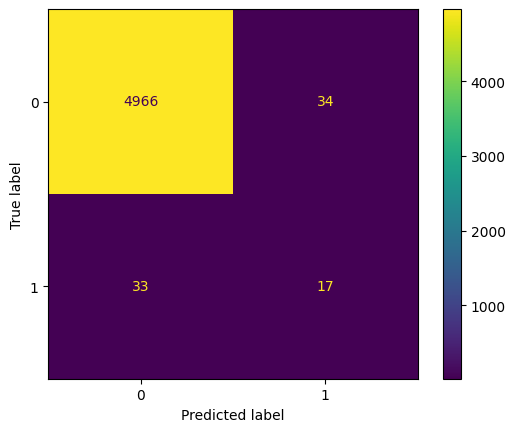

In [101]:
# train

model = IsolationForest(contamination=contamination_best, bootstrap=bootstrap_best, n_jobs=n_job_best, n_estimators=n_estimator_best, max_samples=max_sample_best, random_state=42)

df['anomaly'] = model.fit_predict(df)

# Étiquettes réelles : 1 pour anomalies, 0 pour normales
true_labels = np.concatenate([np.zeros(5000), np.ones(50)])

# Recalculer les étiquettes prédites : -1 -> 1 (anomalie) et 1 -> 0 (normal)
predicted_labels = (df['anomaly'] == -1).astype(int)

# 1. Matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)
#print("Matrice de confusion :\n", conf_matrix)
ConfusionMatrixDisplay(conf_matrix).plot()

# 2. Rapport de classification
report = classification_report(true_labels, predicted_labels)
print("\nRapport de classification :\n", report)

# 3. Précision globale
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Précision globale : {accuracy:.2f}")

on detect seulement la moitier anomaly malgré les 99% de précision

il faudrait changé la méthode de scoring
il faudrait aussi prendre le temps de lancer le serchgrid pour trouver de meilleurs parametres


on conclut que se modèle 